# T2 Decay Measurement Notebook
This notebook compares T2 decay extracted from three pulse sequences: Hahn Echo, Carr-Purcell (CP), and Carr-Purcell-Meiboom-Gill (CPMG).

## Imports

In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import hilbert
from scipy.optimize import curve_fit
import os


## Load Data

In [6]:
import re

# Assume your data files are in subfolders named 'hahn', 'cp', and 'cpmg'
def load_data(folder, prefix):
    data = []
    pulse_times = []
    for fname in sorted(os.listdir(folder)):
        # Check that file is CSV and is of the form "PREFIXNUMBER.csv"
        if fname.endswith('.csv') and re.match(rf'^{prefix}\d+\.csv$', fname):
            pulse_time = 50
            df = pd.read_csv(os.path.join(folder, fname), header=None, names=['t', 'CH1', 'CH2']).dropna()
            df = df[(df['t'] > 0.007) & (df['t'] < 0.042)]
            df['CH1'] = -(df['CH1'] - df['CH1'].mean())
            df['CH2'] = df['CH2'] - df['CH2'].mean()

            # Subtract linear fit
            x = df['t']
            y = df['CH1']
            coeffs = np.polyfit(x, y, 1)
            linear_fit = np.polyval(coeffs, x)
            df['CH1'] -= linear_fit

            # Subract linear fit from CH2
            y = df['CH2']
            coeffs = np.polyfit(x, y, 1)
            linear_fit = np.polyval(coeffs, x)
            df['CH2'] -= linear_fit
            
            data.append(df)
            pulse_times.append(pulse_time)
    return data, pulse_times

# hahn_data, hahn_times = load_data('327', 'HAHN')
cp_data, cp_times = load_data('327', "CP")
cpmg_data, cpmg_times = load_data('327', "CPMG")


## Model Definition

In [7]:

def model_exp(t, A, T2, C):
    return A * np.exp(-t / T2) + C

def fit_decay(df, prominence=0.2, min_distance=100):
    t = df['t'].values
    real_signal = df['CH1'].values
    peaks, _ = find_peaks(real_signal, prominence=prominence, distance=min_distance)
    t_peaks = t[peaks]
    amp_peaks = real_signal[peaks]
    if len(t_peaks) < 3:
        return [np.nan, np.nan, np.nan], t_peaks, amp_peaks
    p0 = [amp_peaks[0], (t.max() - t.min()) / 2, np.min(amp_peaks)]
    popt, _ = curve_fit(model_exp, t_peaks, amp_peaks, p0=p0)
    return popt, t_peaks, amp_peaks


## Robust Echo Detection Using Hilbert Envelope
To avoid pulse artifacts and extract clean echo peaks, we use the Hilbert transform to compute the envelope of the signal. This lets us find only the main echo peaks, and ignore the high-frequency oscillations within each echo and the large transient artifacts near the pulses.

In [8]:

def fit_decay_envelope(df, channel='CH1', prominence=0.2, min_distance=150, pulse_threshold=0.95, left_mask_window=125, right_mask_window=125):
    t = df['t'].values
    signal_raw = df[channel].values
    
    # 1. Min-max scale the signal
    scaled = (signal_raw - np.min(signal_raw)) / (np.max(signal_raw) - np.min(signal_raw))

    # 2. Detect and mask where scaled signal > 0.95
    mask = np.ones_like(signal_raw, dtype=bool)
    pulse_locs = np.where(scaled > pulse_threshold)[0]
    for p in pulse_locs:
        mask[max(0, p - left_mask_window):min(len(mask), p + right_mask_window)] = False

    
    # 2. Compute Hilbert envelope
    analytic_signal = hilbert(signal_raw)
    from scipy.ndimage import gaussian_filter1d

    envelope = np.abs(analytic_signal)

    # Smooth envelope using Gaussian filter
    envelope = gaussian_filter1d(envelope, sigma=10)

    envelope[~mask] = 0



    
    # 3. Find peaks in the envelope where not masked
    t_masked = t[mask]
    env_masked = envelope[mask]
    peak_indices, _ = find_peaks(env_masked, prominence=prominence, distance=min_distance)
    t_peaks = t_masked[peak_indices]
    amp_peaks = env_masked[peak_indices]
    
    if len(t_peaks) < 3:
        return [np.nan, np.nan, np.nan], t_peaks, amp_peaks, envelope
    p0 = [amp_peaks[0], (t_peaks[-1] - t_peaks[0]) / 2, amp_peaks[-1]]
    popt, _ = curve_fit(model_exp, t_peaks, amp_peaks, p0=p0, maxfev=10000)
    return popt, t_peaks, amp_peaks, envelope


In [9]:
def analyze_with_envelope(data, pulse_times):
    results = []
    all_fits = []

    for idx, df in enumerate(data):
        # Real (CH1)
        popt_real, t_peaks_r, amp_peaks_r, env_r = fit_decay_envelope(df, channel='CH1', prominence=0.2)
        # Imaginary (CH2)
        popt_imag, t_peaks_i, amp_peaks_i, env_i = fit_decay_envelope(df, channel='CH2', prominence=0.2)

        results.append({
            'Pulse Time (us)': pulse_times[idx],
            'T2_Real (us)': popt_real[1],
            'T2_Imag (us)': popt_imag[1],
            'A_Real': popt_real[0],
            'A_Imag': popt_imag[0],
            'C_Real': popt_real[2],
            'C_Imag': popt_imag[2],
        })

        all_fits.append({
            't': df['t'].values,
            'CH1': df['CH1'].values,
            'CH2': df['CH2'].values,
            'Envelope_CH1': env_r,
            'Envelope_CH2': env_i,
            't_peaks_CH1': t_peaks_r,
            't_peaks_CH2': t_peaks_i,
            'amp_peaks_CH1': amp_peaks_r,
            'amp_peaks_CH2': amp_peaks_i,
            'fit_CH1': popt_real,
            'fit_CH2': popt_imag,
        })

    return pd.DataFrame(results), all_fits


# hahn_results, hahn_fits = analyze_with_envelope(hahn_data, hahn_times)
cp_results, cp_fits = analyze_with_envelope(cp_data, cp_times)
cpmg_results, cpmg_fits = analyze_with_envelope(cpmg_data, cpmg_times)

# display(hahn_results)
display(cp_results)
display(cpmg_results)


,Pulse Time (us),T2_Real (us),T2_Imag (us),A_Real,A_Imag,C_Real,C_Imag
0,50,0.008069,0.008017,5.678056,5.461024,0.438146,0.409954
1,50,0.007483,0.007085,5.649911,5.900197,0.418553,0.389721
2,50,0.007104,0.007056,6.748979,6.469233,0.420193,0.367826
3,50,0.007599,0.007921,5.567370,5.105848,0.480109,0.418035
4,50,0.008231,0.008178,5.161095,5.006941,0.444957,0.424986
5,50,0.007730,0.007925,5.589602,5.121314,0.465746,0.435347
6,50,0.007341,0.007227,6.116002,5.949716,0.433222,0.392743
7,50,0.007424,0.007341,6.017578,5.785789,0.440604,0.424792
8,50,0.008279,0.008090,5.392261,5.139172,0.444269,0.434213
9,50,0.008141,0.008213,5.408330,5.289138,0.446819,0.397316


,Pulse Time (us),T2_Real (us),T2_Imag (us),A_Real,A_Imag,C_Real,C_Imag
0,50,0.020499,0.019991,3.024912,2.864696,0.148180,0.183927
1,50,0.021689,0.022210,2.988317,2.726124,0.140911,0.160913
2,50,0.025405,0.025018,2.923247,2.758660,0.065991,0.070639
3,50,0.025179,0.023391,2.943277,2.775096,0.035607,0.103579
4,50,0.026014,0.027405,2.911933,2.780191,0.033294,-0.020544
5,50,0.026676,0.022761,3.032387,2.821115,-0.054186,0.110804
6,50,0.021668,0.023161,2.994650,2.837640,0.140266,0.068465
7,50,0.019522,0.021407,2.922425,2.781236,0.262406,0.165951
8,50,0.024117,0.025580,2.927913,2.820736,0.082572,0.016425
9,50,0.018651,0.019521,3.040982,2.902335,0.265042,0.198605


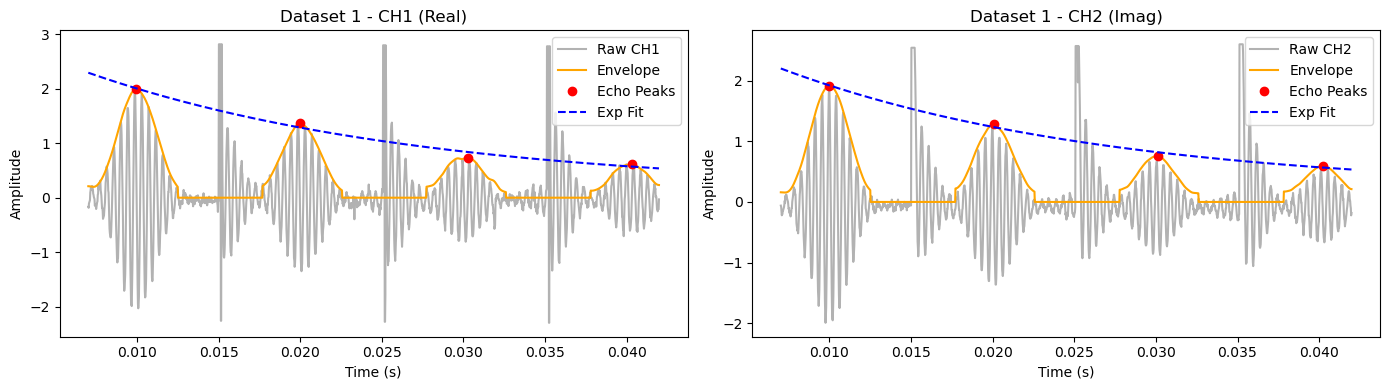

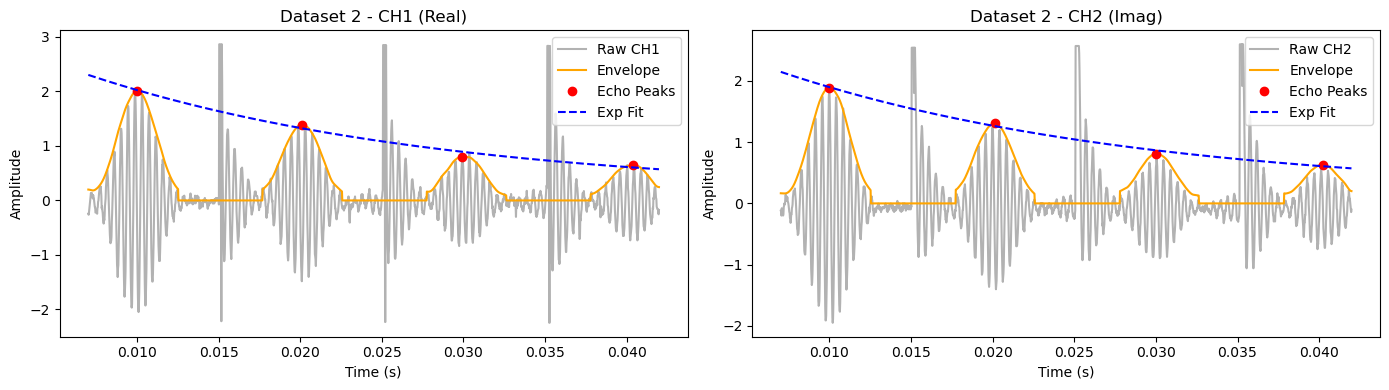

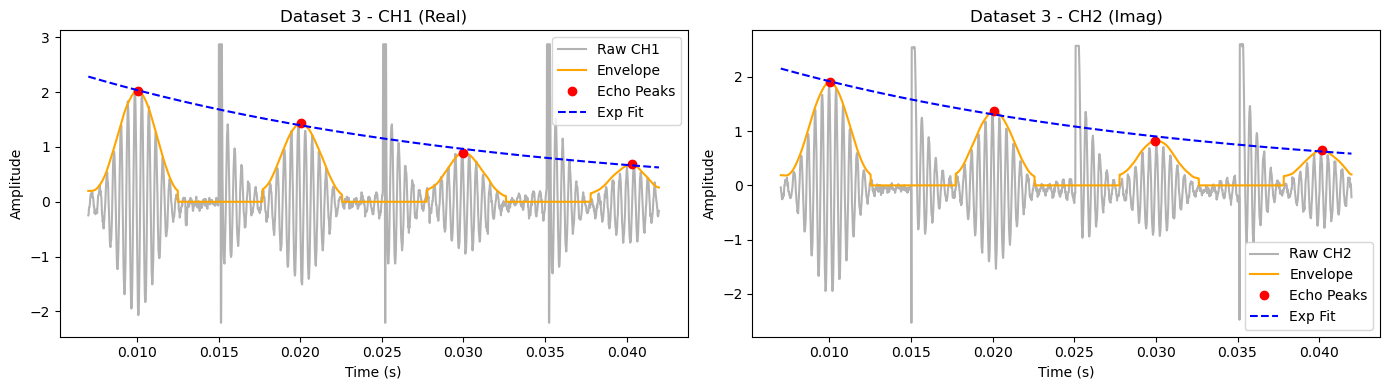

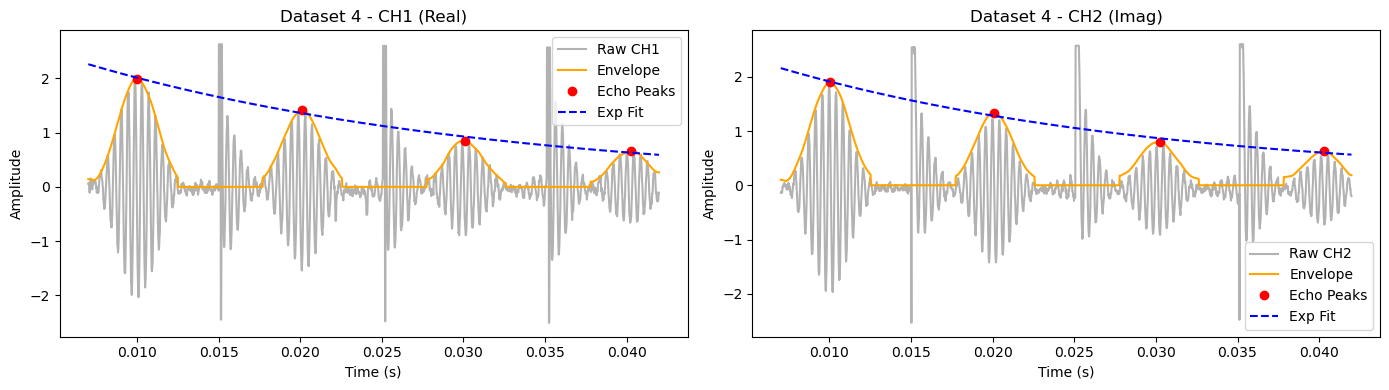

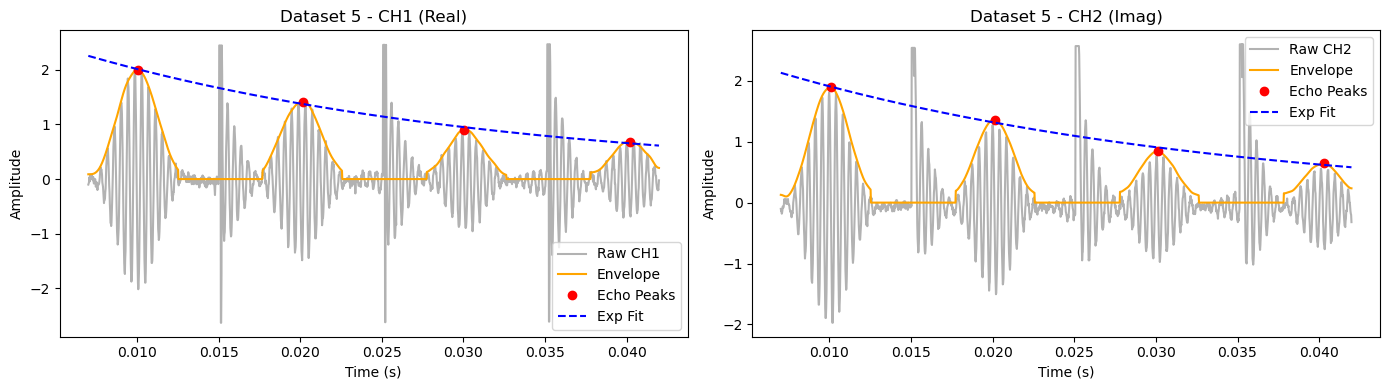

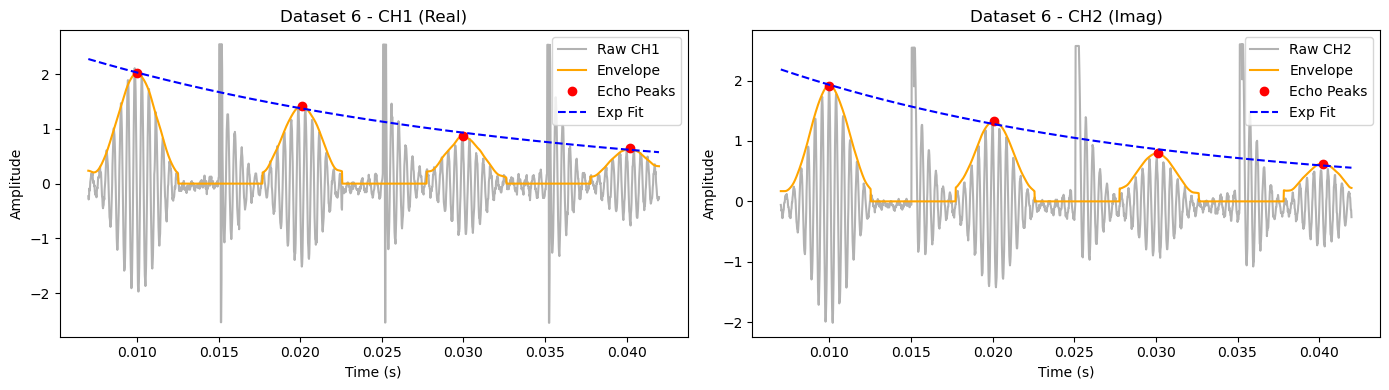

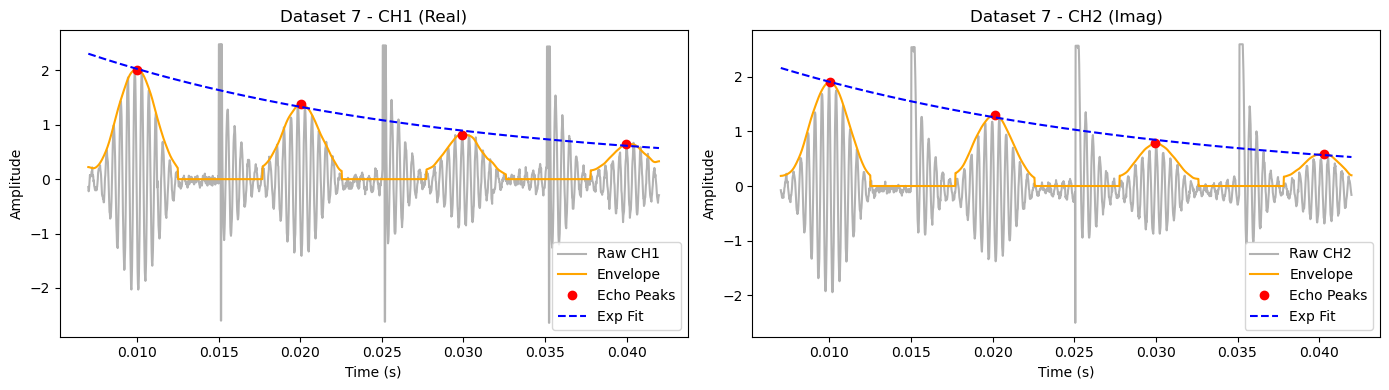

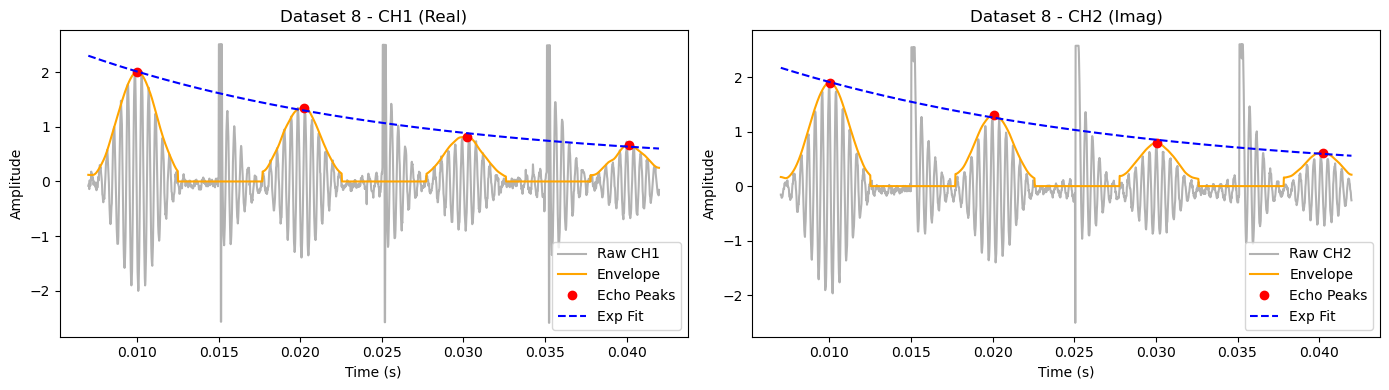

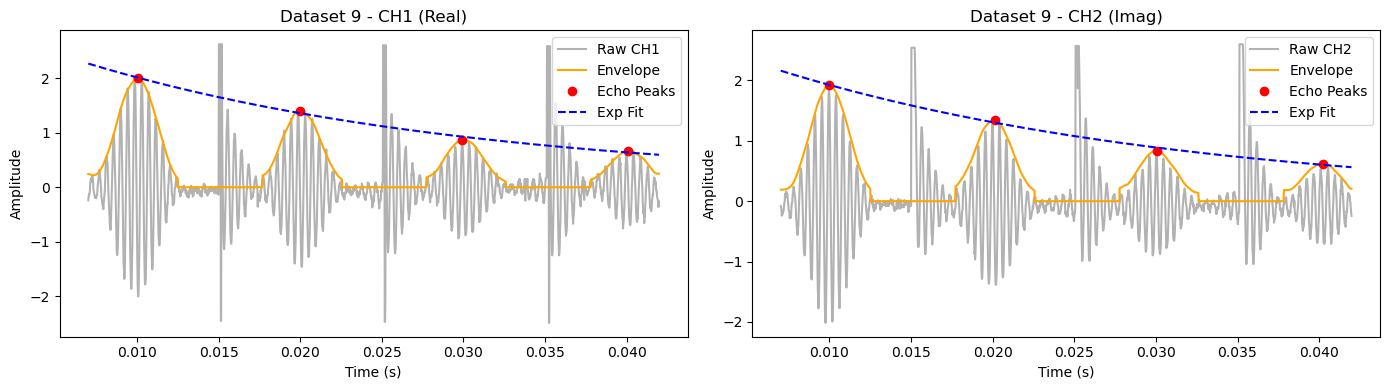

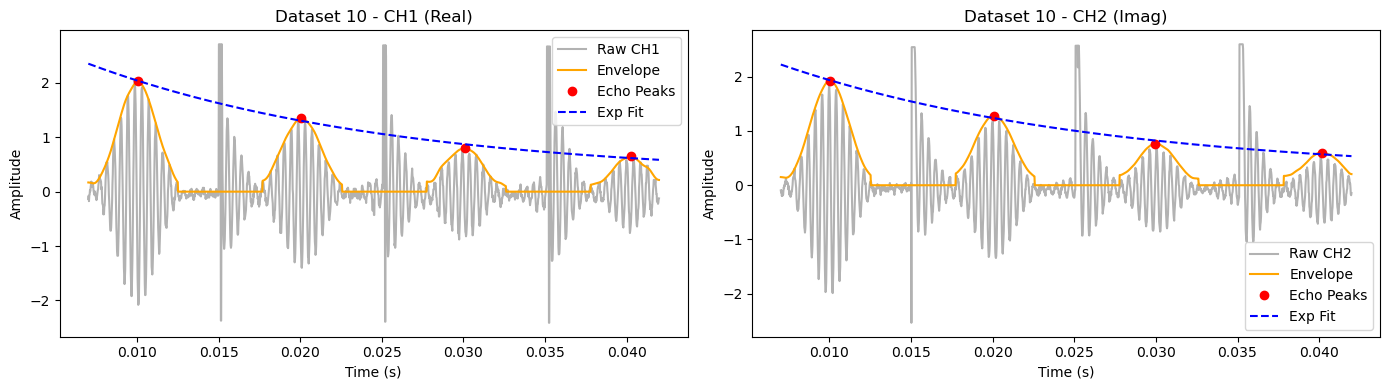

In [10]:
for i, fit in enumerate(cpmg_fits):  # plot a few examples
    t = fit['t']
    
    # CH1 (Real)
    raw1 = fit['CH1']
    env1 = fit['Envelope_CH1']
    t_peaks1 = fit['t_peaks_CH1']
    amp_peaks1 = fit['amp_peaks_CH1']
    popt1 = fit['fit_CH1']

    # CH2 (Imag)
    raw2 = fit['CH2']
    env2 = fit['Envelope_CH2']
    t_peaks2 = fit['t_peaks_CH2']
    amp_peaks2 = fit['amp_peaks_CH2']
    popt2 = fit['fit_CH2']
    
    plt.figure(figsize=(14, 4))

    # --- CH1 (Real) ---
    plt.subplot(1, 2, 1)
    plt.plot(t, raw1, 'k-', alpha=0.3, label='Raw CH1')
    plt.plot(t, env1, 'orange', label='Envelope')
    plt.plot(t_peaks1, amp_peaks1, 'ro', label='Echo Peaks')
    if not np.isnan(popt1).any():
        plt.plot(t, model_exp(t, *popt1), 'b--', label='Exp Fit')
    plt.title(f'Dataset {i+1} - CH1 (Real)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    # --- CH2 (Imag) ---
    plt.subplot(1, 2, 2)
    plt.plot(t, raw2, 'k-', alpha=0.3, label='Raw CH2')
    plt.plot(t, env2, 'orange', label='Envelope')
    plt.plot(t_peaks2, amp_peaks2, 'ro', label='Echo Peaks')
    if not np.isnan(popt2).any():
        plt.plot(t, model_exp(t, *popt2), 'b--', label='Exp Fit')
    plt.title(f'Dataset {i+1} - CH2 (Imag)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
# --- Summary statistics for T2 ---
t2_real = cp_results['T2_Real (us)'].dropna() / 1e-3
t2_imag = cp_results['T2_Imag (us)'].dropna() / 1e-3

def summarize(series, label):
    mean = series.mean()
    std = series.std()
    sem = std / np.sqrt(len(series))
    ci95 = 1.96 * sem
    print(f"{label}:\n  Mean T2 = {mean:.4f} ms\n  Std = {std:.4f}\n  SEM = {sem:.4f}\n  95% CI = ±{ci95:.4f}\n")

print("--- CP RESULTS ---")
summarize(t2_real, "CH1 (Real)")
summarize(t2_imag, "CH2 (Imag)")

# --- Summary statistics for T2 ---
t2_real = cpmg_results['T2_Real (us)'].dropna() / 1e-3
t2_imag = cpmg_results['T2_Imag (us)'].dropna() / 1e-3

def summarize(series, label):
    mean = series.mean()
    std = series.std()
    sem = std / np.sqrt(len(series))
    ci95 = 1.96 * sem
    print(f"{label}:\n  Mean T2 = {mean:.4f} ms\n  Std = {std:.4f}\n  SEM = {sem:.4f}\n  95% CI = ±{ci95:.4f}\n")

print("--- CPMG RESULTS ---")
summarize(t2_real, "CH1 (Real)")
summarize(t2_imag, "CH2 (Imag)")

--- CP RESULTS ---
CH1 (Real):
  Mean T2 = 7.7400 ms
  Std = 0.4151
  SEM = 0.1313
  95% CI = ±0.2573

CH2 (Imag):
  Mean T2 = 7.7054 ms
  Std = 0.4702
  SEM = 0.1487
  95% CI = ±0.2914

--- CPMG RESULTS ---
CH1 (Real):
  Mean T2 = 22.9421 ms
  Std = 2.8889
  SEM = 0.9135
  95% CI = ±1.7905

CH2 (Imag):
  Mean T2 = 23.0444 ms
  Std = 2.4645
  SEM = 0.7794
  95% CI = ±1.5275



In [12]:
(7.6849 + 7.7564) / 2, np.sqrt(0.6099**2 + 0.4846**2), (24.6494 + 24.1451) / 2, np.sqrt(4.9179**2 + 2.3306**2)

(7.72065,
 np.float64(0.7789834208762083),
 24.39725,
 np.float64(5.442190438600987))